In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
from cartopy import config
from cartopy.io import shapereader
from geopy.geocoders import Nominatim
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
# read city information
CITIES=pd.read_excel('/nfs/turbo/seas-mtcraig-climate/Haochi/PVTemp_Bias_Corr/Figure/First_GIS_analysis/data/CITIES.xlsx')

df=CITIES.copy()
drop_cities=['Jaipur','Ibadan','Hangzhou',"Xi'an",'Jinan']
for drop_city in drop_cities:
    drop_index=CITIES[CITIES['Cities'] == drop_city].index
    df=df.drop(labels=drop_index, axis=0)

In [3]:
def read_temp(X):
    # read hot-hours data for +XC warming compared with preindustrial period
    mount_method='close_mount_glass_glass'
    gcm_path2 = f'/nfs/turbo/seas-mtcraig-climate/Haochi/PVTemp_Bias_Corr/0508_update_figure/13_Purdue_ERA5_temp'
    path = (gcm_path2+f'/Model_avg_PVT98_Hourly_ERA5_{mount_method}_{X}_degC.nc')
    result=xr.open_dataset(path)["pvtemp_deg°C"]
    return result

# read hot-hours data for 1.5, 2, 3, 4C degree warming compared with preindustrial period
hothours={}
for X in [0.8,1.5,2,3,4]:
    tmp=read_temp(X) # multiply 3 since the original hot-hours are calculated from 3-hourly data
    hothours[X]=tmp
hothours=xr.concat(list(hothours.values()),dim='X')
hothours['X']=[0.8,1.5,2,3,4]

In [4]:
color=np.array([
    [225,225,225],
    [255, 245, 204],
    [255, 230, 112],
    [255, 204,  51],
    [255, 175,  51],
    [255, 153,  51],
    [255, 111,  51],
    [255,  85,   0],
    [230,  40,  30],
    [200,  30,  20]])
color = np.array([
    [225, 225, 225],  # Light gray
    [255, 245, 204],  # Light yellow
    [255, 230, 112],  # Yellow
    [255, 204, 51],  # Orange-yellow
    [255, 175, 51],
    [255, 153, 51],
    # [213, 14, 159], # 1
    [179, 20, 25], #1
    [160, 10, 120], #2
    [95, 12, 180], #3
    [64, 8, 120],#4
    # [235, 28, 36], #1 -2
    # [179, 20, 25], #2
    # [118, 14, 18], #3
    # [106, 8, 80] #4
    # [128, 0, 128],  # 1 Purple, transitioning from extreme to higher risk
    # [255, 0, 255],  # 2 Magenta, further increasing risk
    # [230, 40, 30],  #  3 Red
    # [200, 30, 20]  # 4 Dark red
])
cmap=mpl.colors.ListedColormap(color/255.)

In [5]:
# interpolate NaN values around 0E
def interp(data):
    data2=data.copy()
    longitude=data.lon
    longitude=xr.where(longitude>180,longitude-360,longitude)
    data2['lon']=longitude
    data2=data2.sortby('lon')
    loc=0
    locnew=np.array([loc-1,loc-0.75,loc-0.5,loc-0.25,loc,loc+0.25,loc+0.5,loc+0.75,loc+1])
    tmp=data2.drop_sel(lon=locnew)
    tmp2=tmp.interp(lon=data2.lon.values)
    longitude2=tmp2.lon
    longitude2=xr.where(longitude2<0,longitude2+360,longitude2)
    tmp2['lon']=longitude2
    return tmp2.sortby('lon')

In [6]:
# define regions lat-lon range
region_names=['South Asia', 'East Asia', 'Africa', 'Middle East', 'North America','Middle Ocean']
lat_lon={'East Asia': {'lat1':7,
                       'lat2':56,
                       'lon1':100,
                       'lon2':137},
         'South Asia':{'lat1':7,
                       'lat2':35,
                       'lon1':63,
                       'lon2':95},
         'North America':{'lat1':10,
                          'lat2':48,
                          'lon1':-120,
                          'lon2':-77},
         'Africa':{'lat1':-3,
                   'lat2':25,
                   'lon1':-15,
                   'lon2':30},
         'Middle East':{'lat1':8,
                        'lat2':36,
                        'lon1':35,
                        'lon2':60},
        'Middle Ocean':{'lat1':50.89,
                    'lat2':27,
                    'lon1':-14,
                    'lon2':42},
         'South America':{'lat1':8,
            'lat2':-50,
            'lon1':-83,
            'lon2':-32},
         
        }

In [23]:
# adjust the position of the labels for certain cities on the map
adjust_cities=['Faisalabad','Karachi','Kolkata','Multan','Chattogram','Guangzhou','Chongqing','Changsha',
              'Shanghai','Hangzhou','Beijing','Nanjing','Tianjin','Osaka','Ha Noi','Philadelphia','Houston',
              'Chicago','Cartagena','Dubai','Mecca','Aden','Basra','Dammam','Khartoum',
              'Kumasi','Lome','Lagos','Bandar Abbas','Wuhan','Tokyo','New York','Detroit','Busan']
lat_offsets={'Faisalabad':-0.5,'Karachi':-1.25,'Kolkata':0,'Chattogram':-0.8,'Guangzhou':0.2,
         'Chongqing':-2,'Changsha':-1.7,'Shanghai':0,'Hangzhou':-0.3,'Beijing':0.15,
         'Tianjin':-1.5,'Osaka':-1,'Ha Noi':0.15,'Philadelphia':-0.5,'Houston':0.5,
         'Chicago':-0.5,'Cartagena':-0.6,'Dubai':0.25,'Mecca':-0.6,'Aden':-0.6,'Basra':0.18,
         'Dammam':0,'Khartoum':2.5,'Kumasi':0.2,'Lome':-1.6,'Multan':-0.6,'Lagos':-0.2,
            'Nanjing':0.15,'Bandar Abbas':0.5,'Wuhan':-1.5,'Tokyo':1,'New York':1.6,'Detroit':1.3,'Busan':0.2}
lon_offsets={'Faisalabad':-8,'Karachi':-4.5,'Kolkata':-4.5,'Chattogram':-1,'Guangzhou':-1,
         'Chongqing':-5,'Changsha':-5,'Shanghai':0.5,'Hangzhou':0.3,'Beijing':-6,
         'Tianjin':-5,'Osaka':0.3,'Ha Noi':-1.5,'Philadelphia':-6,'Houston':-3.3,
         'Chicago':-9,'Cartagena':0.15,'Dubai':-2.8,'Mecca':0.15,'Aden':0.15,'Basra':-3.2,
         'Dammam':-5.3,'Khartoum':-9,'Kumasi':-3,'Lome':-2,'Multan':0.3,'Lagos':0.3,
            'Nanjing':-6,'Bandar Abbas':-4,'Wuhan':0,'Tokyo':-3,'New York':-4,'Detroit':-8,'Busan':-3}

# 读取城市数据
cities_file_path = '/nfs/turbo/seas-mtcraig-climate/Haochi/Cities/DATA_Manoli_NATURE_2019.xls'
cities_df = pd.read_excel(cities_file_path)

# 根据人口排序并选取前3000个城市
sorted_cities_df = cities_df.sort_values(by='POP_2000', ascending=False).head(3000)
sorted_cities_df=sorted_cities_df.groupby('ISO3').head(50)
# 读取包含ISO3和UN Geographical Sub-Region对应关系的文件
regions_file_path = '/nfs/turbo/seas-mtcraig-climate/Haochi/Cities/ipcc-inform-gri-2019-v0-3-7-xlsx.xlsx'
regions_df = pd.read_excel(regions_file_path, sheet_name='Regions', header=1)
merged_df = pd.merge(sorted_cities_df, regions_df[['ISO3', 'UN Geographical Sub-Region']], on='ISO3', how='left')
# 查看合并后的数据集
print(merged_df[['LAT', 'LON', 'URBID', 'NAME', 'ISO3', 'UN Geographical Sub-Region']].head())
sorted_cities_df.loc[sorted_cities_df["LON"] < 180, "LON"] += 360
location_of_cities = sorted_cities_df[['LAT', 'LON', 'POP_2000',  'NAME','ISO3']].values.tolist()



         LAT         LON  URBID        NAME ISO3 UN Geographical Sub-Region
0  34.972671  136.389421  37372       TOKYO  JPN               Eastern Asia
1  19.504818  -99.060949  51793  MEXICOCITY  MEX            Central America
2  22.873056  113.579442  49534    SHENZHEN  CHN               Eastern Asia
3  40.681595  -74.015978  28505     NEWYORK  USA           Northern America
4  -6.290612  106.765614  59607     JAKARTA  IDN         South-Eastern Asia


In [8]:
# Compute the marker sizes based on population


print(1+ 0.5e-2*sorted_cities_df['POP_2000']**0.4)
location_of_cities

9740     8.196167
15535    5.685026
14646    5.642324
6137     5.420128
18157    5.151383
           ...   
3351     1.533186
16383    1.533121
17683    1.532957
17496    1.532893
21367    1.532799
Name: POP_2000, Length: 1760, dtype: float64


[[34.9726712491, 496.38942133800003, 78582895.0, 'TOKYO', 'JPN'],
 [19.5048181033, 260.93905112749997, 26875405.0, 'MEXICOCITY', 'MEX'],
 [22.87305588, 473.579442322, 26267183.0, 'SHENZHEN', 'CHN'],
 [40.68159541, 285.9840219463, 23236034.0, 'NEWYORK', 'USA'],
 [-6.29061165151, 466.765613929, 19863559.0, 'JAKARTA', 'IDN'],
 [37.5971772948, 487.011766567, 19763996.0, 'SEOUL', 'KOR'],
 [-23.3217139402, 313.1990926066, 19413359.0, 'SAOPAULO', 'BRA'],
 [33.7952900454, 242.147465778, 17765862.0, 'LOSANGELES', 'USA'],
 [19.1623758644, 433.0107143456, 17418501.0, 'MUMBAI', 'IND'],
 [23.9489707213, 480.743774986, 15457300.0, 'TAIPEI', 'TWN'],
 [-26.1912574913, 388.0188333162, 14452392.0, 'JOHANNESBURG', 'ZAF'],
 [28.6519255622,
  437.2755060956,
  14263683.0,
  'DELHIMUNICIPALCORPORATION',
  'IND'],
 [31.2265214476, 481.412764782, 13744049.0, 'SHANGHAI', 'CHN'],
 [22.7324620245, 448.3784841829, 12827099.0, 'KOLKATA', 'IND'],
 [55.7430984059, 397.6961905513, 12719961.0, 'MOSCOW', 'RUS'],
 [-34.

In [17]:
landmask= regionmask.defined_regions.natural_earth.land_110.mask(hothours,lon_name="lon",lat_name="lat")
import numpy as np
def plot_cities(ax,region,add_cities):
    # plot city dots with annotation, finalize plot
    # lat/lon coordinates of five cities in Bangladesh
    
    for location in location_of_cities:        
        lat, lon, pop, name, iso3  = location
        lon_offset=0.15
        lat_offset=0.15
        ax.plot(lon, lat, "ko", ms=1+ 0.5e-2*pop**0.4,alpha=0.4, transform=ccrs.PlateCarree())
        if add_cities:
            ax.text(lon + lon_offset, lat + lat_offset, str(name), fontsize="small",alpha=0.7, transform=ccrs.PlateCarree())
def subplot_region(data,axis,norm,cmap,lat_lon,region,add_cities):
    region_name=region
    if region_name =='Africa':
        tmp=data.pipe(interp).where(landmask==0)
    else:
        tmp=data.where(landmask==0)
    LON,LAT=np.meshgrid(tmp.lon.values,tmp.lat.values)
    
        
    g=axis.pcolormesh(LON, LAT,tmp,
                      transform=ccrs.PlateCarree(),
                      cmap=cmap,norm=norm,rasterized=True) 
    axis.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='50m', #1:50million; three options: 10m, 50m, 110m
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))
    fpath = str(config['data_dir']) + r'/shapefiles/natural_earth/physical/ne_50m_lakes.shp'
    as_shp = shapereader.Reader( fpath )
    Great_lakes=['Lake Erie','Lake Ontario','Lake Michigan','Lake Superior','Lake Huron']    
    for rec in as_shp.records():
        if rec.attributes['name']  in Great_lakes:
            axis.add_geometries( [rec.geometry], ccrs.PlateCarree(), edgecolor='none', facecolor='white' )
    pass
    axis.add_feature(cfeature.RIVERS.with_scale('50m'),alpha=0.7)
    plot_cities(axis,region,add_cities)

    axis.coastlines(linewidth=0.5,resolution='10m') # add coastlines
    axis.set_title('')
    axis.set_extent([lat_lon['lon1'],lat_lon['lon2'],lat_lon['lat1'],lat_lon['lat2']])
    return g


def plot_each_region(data,region,region_name,lat_lon):
    levels=[60, 70, 72, 74, 76, 78, 80, 82, 84, 90]
    norm=mpl.colors.BoundaryNorm(levels,ncolors=len(levels),extend='max')
    fig = plt.figure(figsize=(15,18))
    Xs=[0.8,1.5,2,3,4]
    anno_opts = dict(xy=(0.02, 0.9), xycoords='axes fraction',va='baseline', ha='left')
    annots={'South Asia':['a', 'b', 'c', 'd'],
            'East Asia':['e', 'f', 'g', 'h'],
            'Africa':['i', 'j', 'k', 'l'],
            'Middle East': ['m', 'n', 'o', 'p'],
            'North America':['q', 'r', 's', 't'],
            'Middle Ocean':['q', 'r', 's', 't']
           }
    
    anno_opts2 = dict(xy=(0.37, 1.05), xycoords='axes fraction',va='baseline', ha='left')
    annots2=['+$0.8^\circ$C','+$1.5^\circ$C','+$2^\circ$C','+$3^\circ$C','+$4^\circ$C']

    center_lat=(lat_lon[region_name]['lat1']+lat_lon[region_name]['lat2'])/2
    center_lon=(lat_lon[region_name]['lon1']+lat_lon[region_name]['lon2'])/2
    for j in range(5):
        add_cities=False if j==3 else False
        tmp=data.sel(X=Xs[j])
        if region_name=='South America':
            ax = fig.add_subplot(1,5,j+1,projection=ccrs.LambertCylindrical(central_longitude=center_lon))
        else:
            ax = fig.add_subplot(1,5,j+1,projection=ccrs.LambertConformal(central_longitude=center_lon,central_latitude=center_lat,cutoff=-60))
        g=subplot_region(tmp,ax,norm,cmap,
                         lat_lon[region_name],region,add_cities)
        # ax.annotate(annots[region_name][j], **anno_opts,fontsize=24)
        ax.annotate(annots2[j], **anno_opts2,fontsize=24)
    fig.subplots_adjust(bottom=0, left=0,right=1, top=1,hspace=0,wspace=0)
    axs=fig.get_axes()
    if region_name=='North America':
        cb=fig.colorbar(g,ax=axs,orientation='horizontal',pad=0.04,shrink=0.75,fraction=.08,aspect=50,ticks=levels)
        cb.set_label(label='Annual hot hours', size=14)
        cb.ax.tick_params(labelsize=12)


/home/haochiw/.local/lib/python3.10/site-packages/regionmask/core/mask.py:178: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


In [10]:
# import cartopy.io.shapereader as shpreader
# def download_ne_50m_lakes():
# # Specify the resolution, category, and name of the shapefile you want to download
#     resolution = '50m'
#     category = 'physical'
#     name = 'lakes'
#     
#     # Use Cartopy's shapereader to download the shapefile
#     shapefile_path = shpreader.natural_earth(resolution=resolution, category=category, name=name)
#     
#     # Print the location of the downloaded shapefile
#     print(f"Downloaded shapefile for {name} at {shapefile_path}")
# 
# # Execute the download function
# download_ne_50m_lakes()

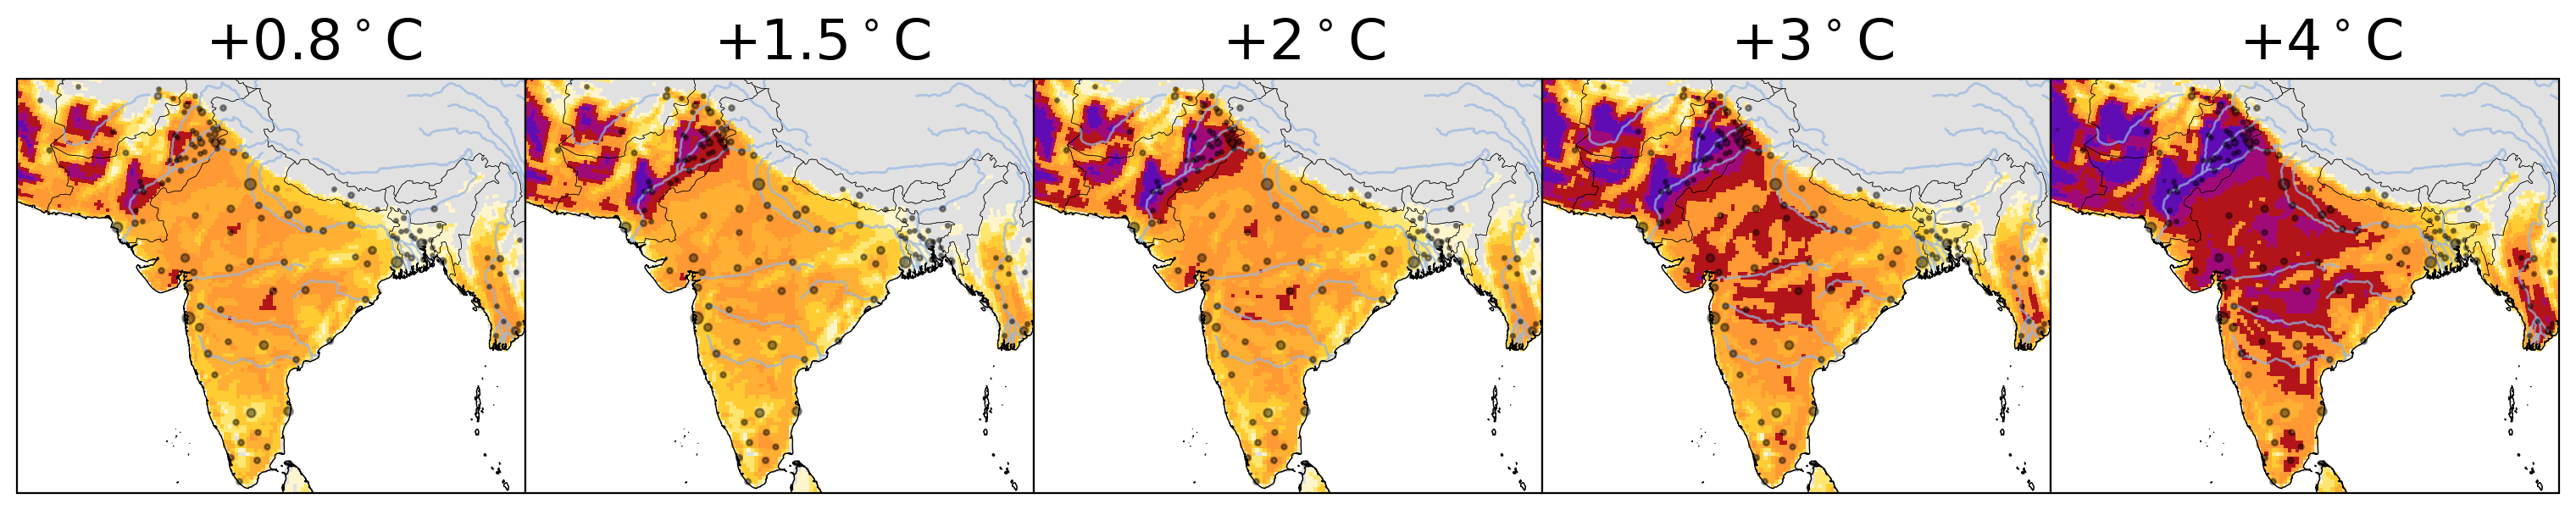

In [18]:
# plot South Asia
plot_each_region(hothours,'South Asia','South Asia',lat_lon)

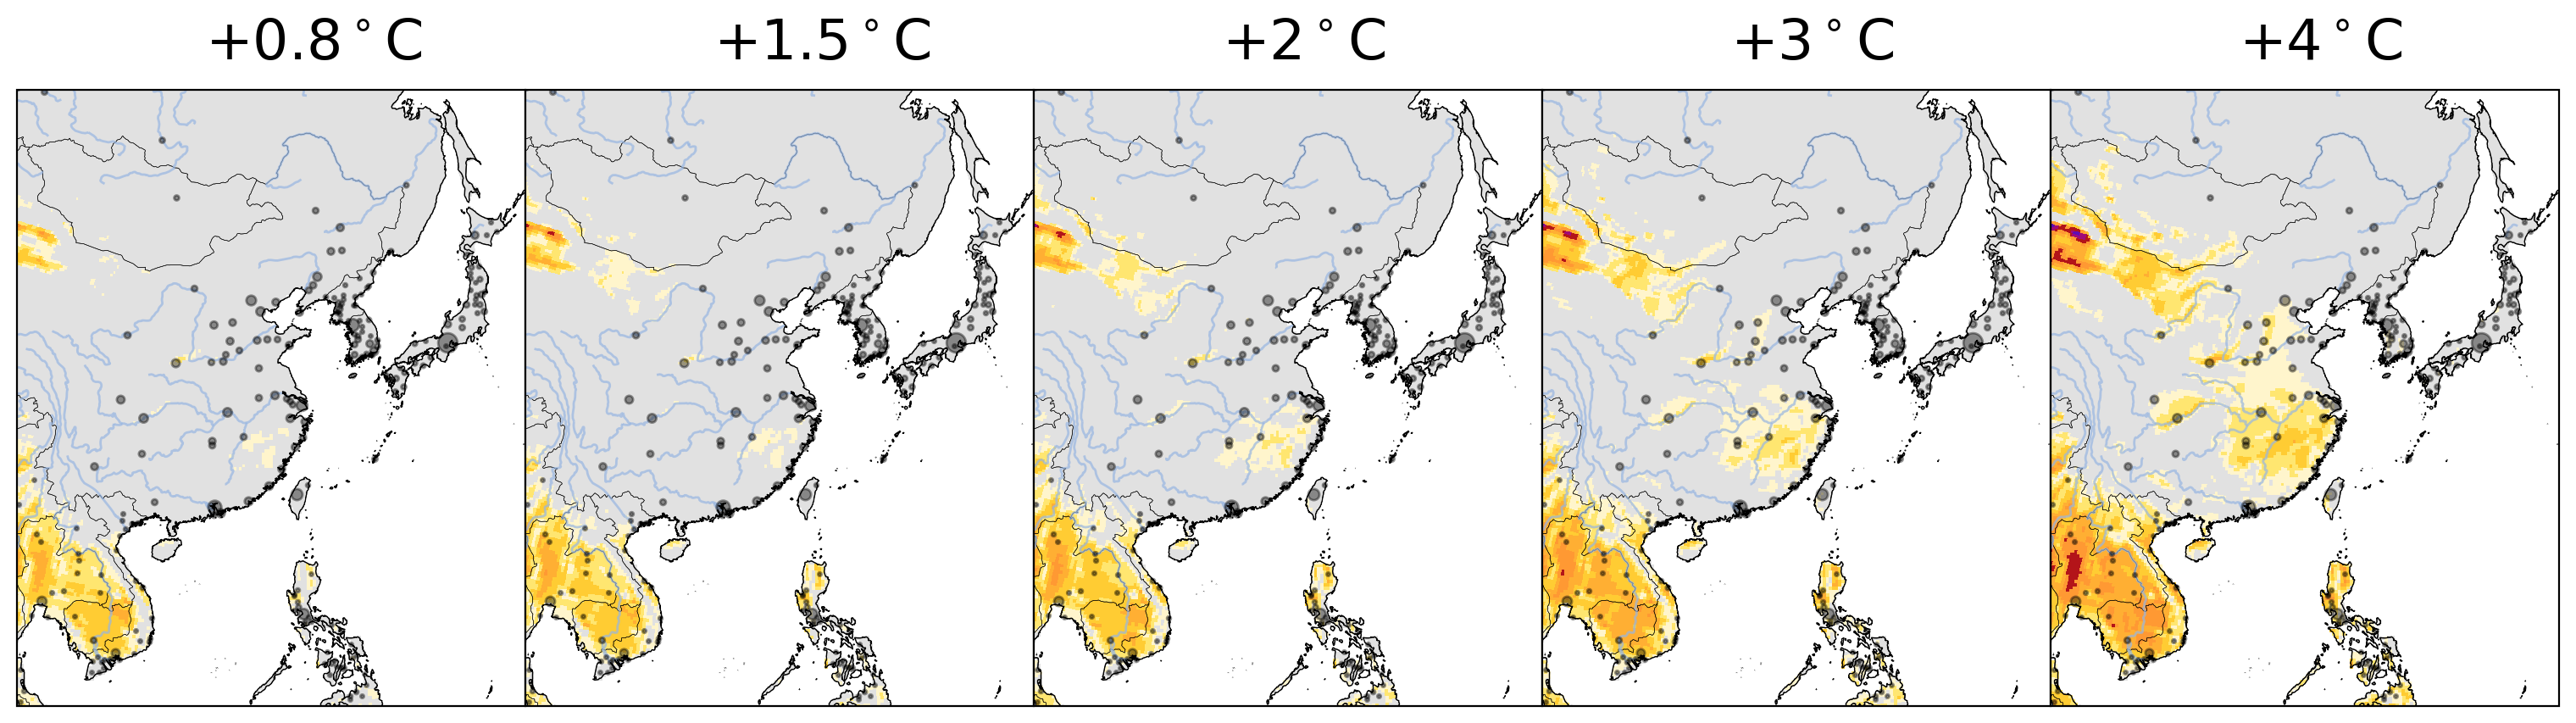

In [19]:
# plot East Asia
plot_each_region(hothours,'East Asia','East Asia',lat_lon)

In [ ]:
# plot Middle East
# plot_each_region(hothours,'Middle East','Middle East',lat_lon) 

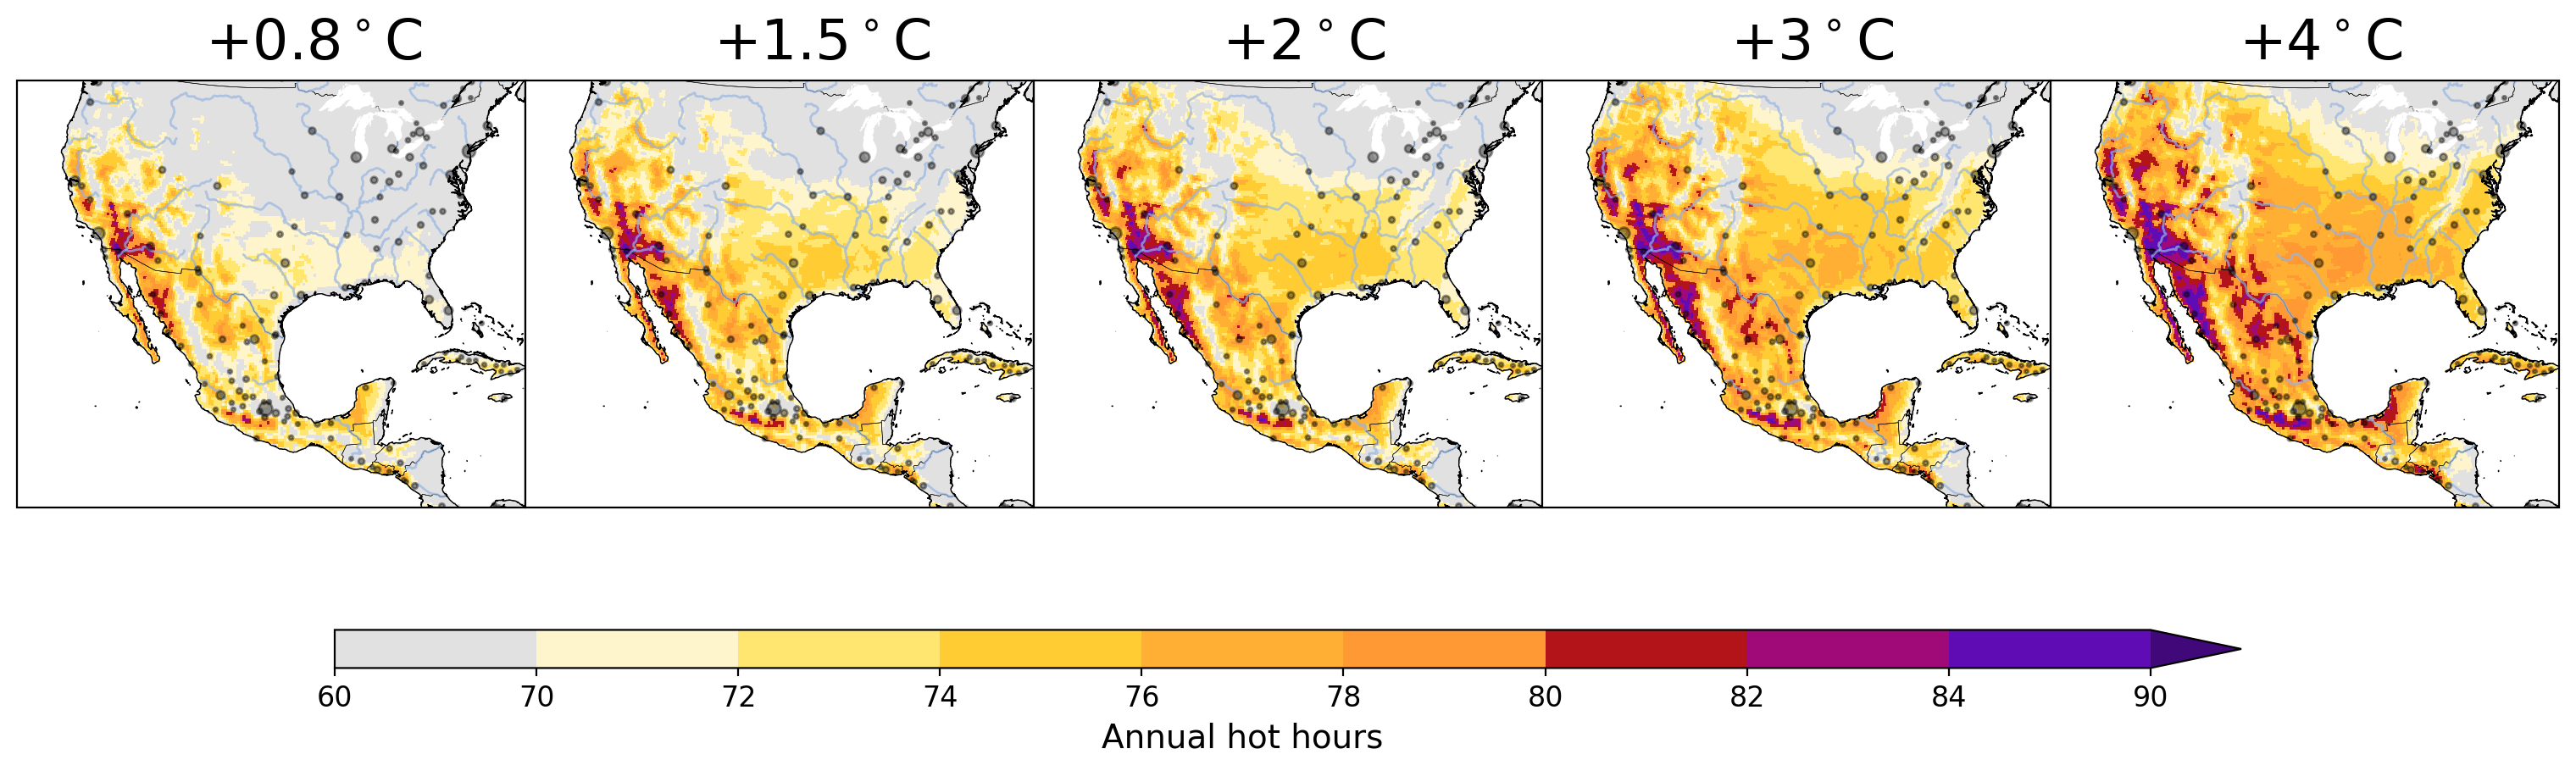

In [20]:
# plot North America
plot_each_region(hothours,'North America','North America',lat_lon)

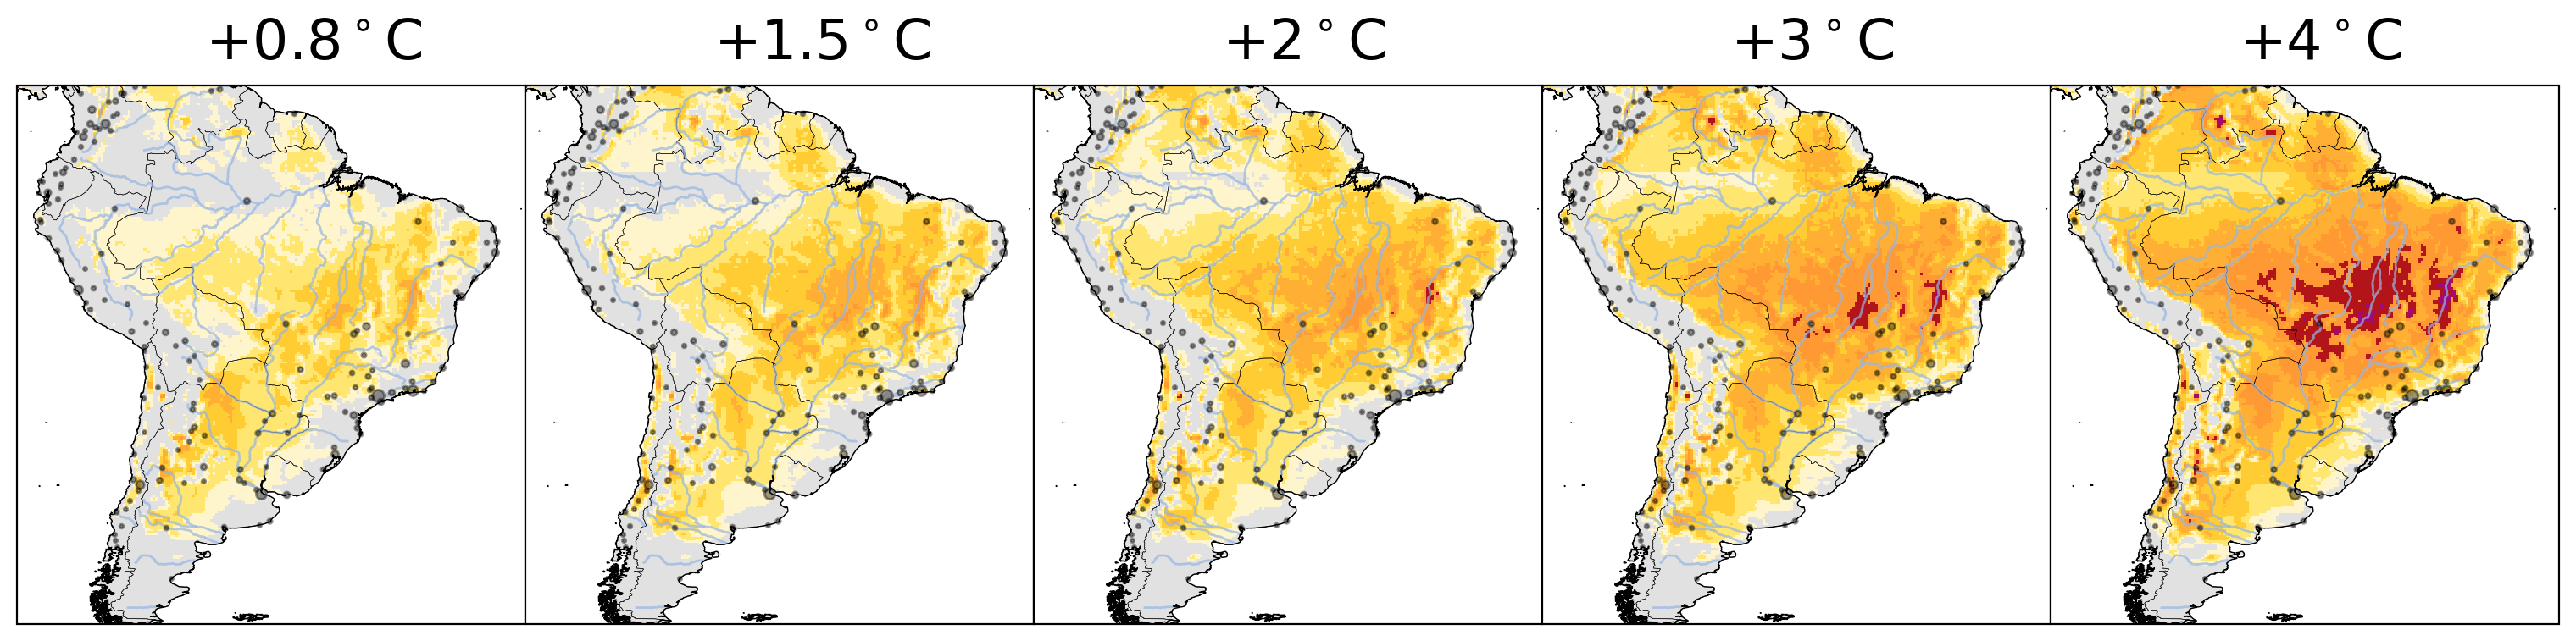

In [21]:
plot_each_region(hothours,'South America','South America',lat_lon)

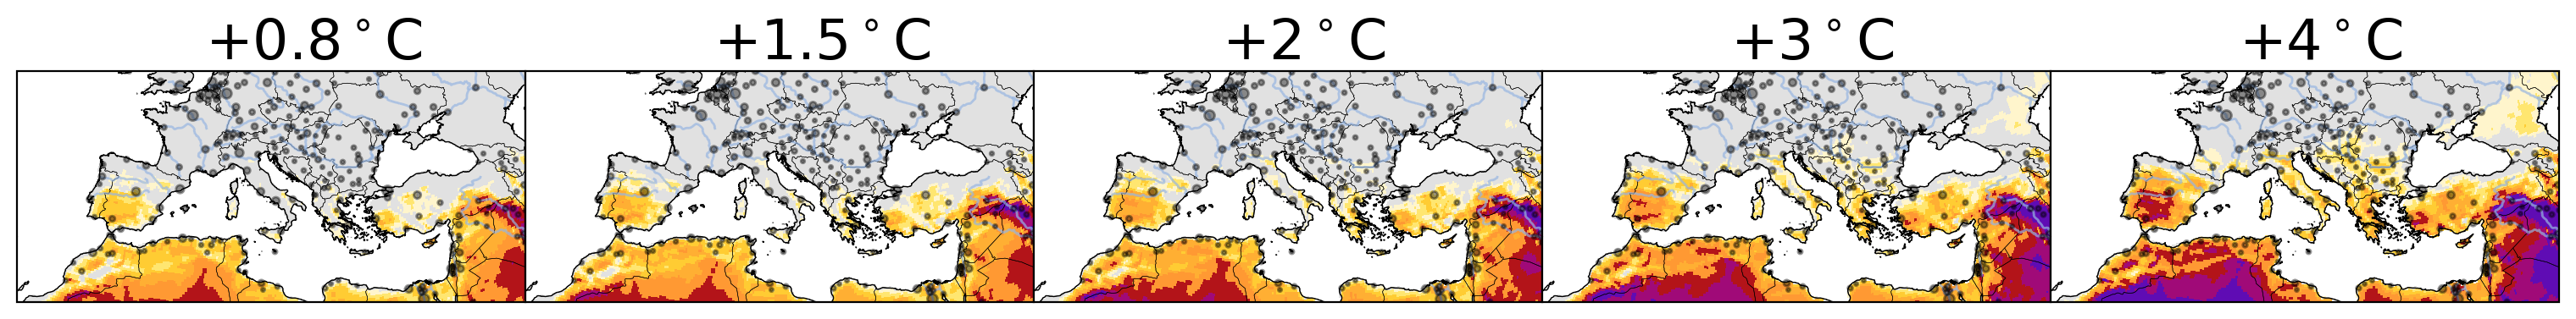

In [24]:
plot_each_region(hothours,'Middle Ocean','Middle Ocean',lat_lon)